### 워드 클라우드

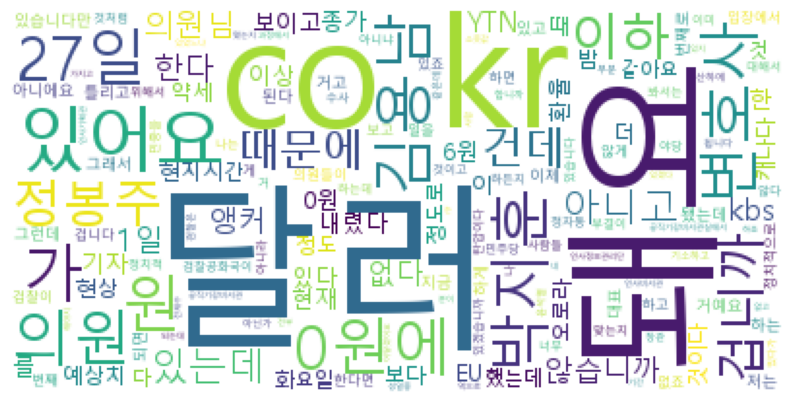

In [1]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud

articles = []

# 시작날짜, 종료날짜 설정
start_date = '20230101'
end_date = '20230228'

# 페이지별로 데이터 추출
for page_no in range(1, 11):
    URL = f"https://news.daum.net/breakingnews/economic/stock/fx?page={page_no}&regDate={start_date},{end_date}"
    res = requests.get(URL)
    soup = BeautifulSoup(res.text)

    article_links = soup.select('div.cont_thumb a.link_txt')
    for link in article_links:
        article_url = link.get('href')
        if 'http' not in article_url:
            continue

        article_response = requests.get(article_url)
        article_soup = BeautifulSoup(article_response.text)
        article_text = article_soup.select('div.article_view')[0].text

        articles.append(article_text.strip().replace('\n', ' '))

# 단어 갯수 세기
word_counts = {}
for article_text in articles:
    for word in article_text.split():
        if word not in word_counts:
            word_counts[word] = 0
        word_counts[word] += 1

text = ' '.join([word for word, count in word_counts.items()])

# 워드클라우드 생성
wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', background_color='white').generate(text)

# 워드클라우드 이미지 출력
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 미국 금리에 따른 한국 금리, 환율 그래프

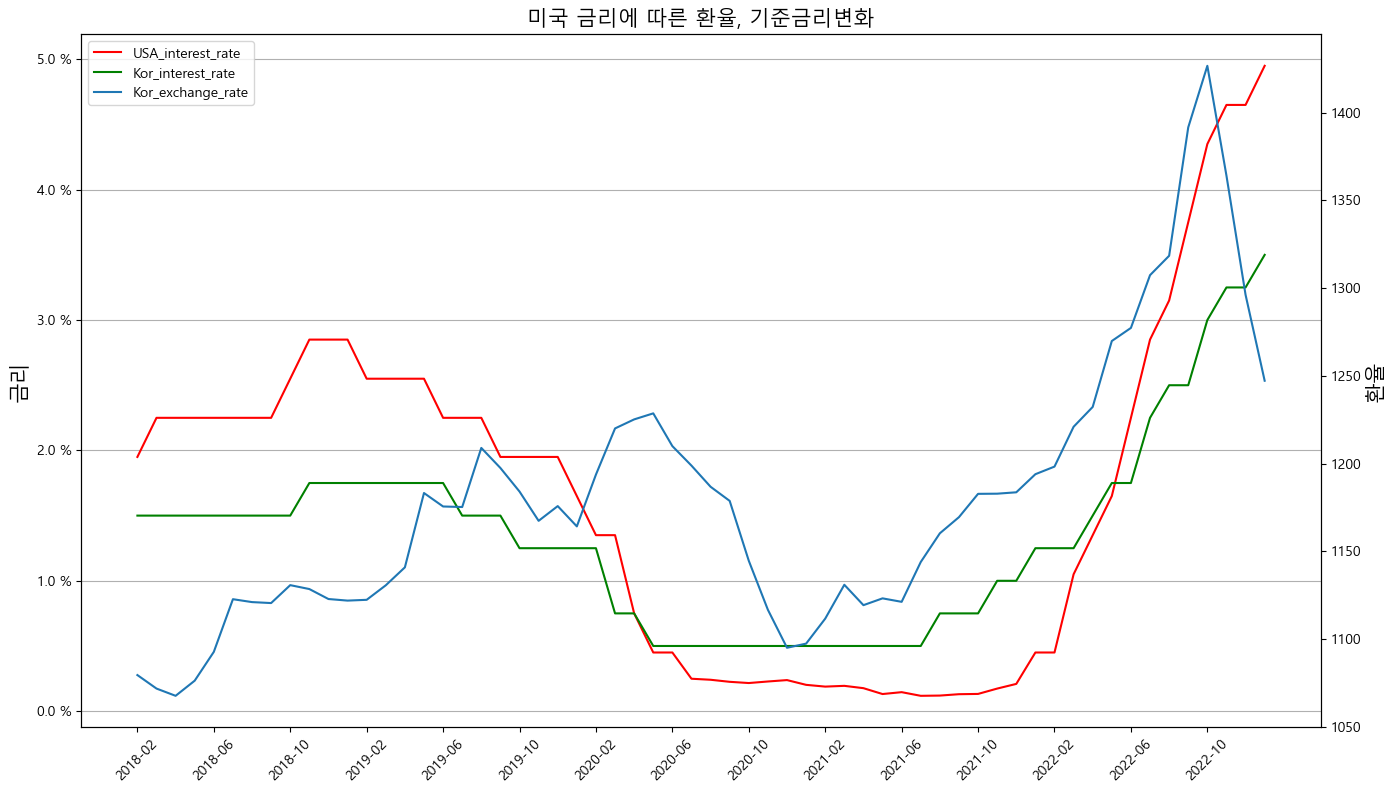

In [49]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import boundary_value_analysis
from matplotlib import font_manager as fm, rc

font = fm.FontProperties(fname='C:\Windows\Fonts\malgun.ttf').get_name()
rc('font', family=font)

# 미국금리 데이터 추출 + 저장
URL = "https://ecos.bok.or.kr/api/StatisticSearch/1A1RCZIVM0QTVI2MN2WO/json/kr/1/65/902Y001/M/201802/202302/1030401"
response = requests.get(URL)
json_result = json.loads(response.text)

USA_rate = []
for item in json_result['StatisticSearch']['row']:
    # 날짜에 "-" 추가
    USA_interest_time = item['TIME'][:4] + "-" + item['TIME'][4:6]
    # 사용자 지정함수사용
    USA_interest = boundary_value_analysis.boundary_value(float(item['DATA_VALUE']))

    USA_rate.append({"TIME":USA_interest_time, "Data_value": USA_interest})

# 파일 저장
with open('USA_interest_rate.json', 'w') as f:
    json.dump(USA_rate, f)

# 원달러 환율 데이터 추출 + 저장
URL = 'https://ecos.bok.or.kr/api/StatisticSearch/1A1RCZIVM0QTVI2MN2WO/json/kr/1/60/731Y004/M/201802/202302/0000001'
response = requests.get(URL)
json_result = json.loads(response.text)

One_dollar = []
for item in json_result['StatisticSearch']['row']:
    # 날짜에 "-" 추가
    Exchange_time = item['TIME'][:4] + "-" + item['TIME'][4:6]
    Exchange = float(item['DATA_VALUE'])
    One_dollar.append({"TIME":Exchange_time, "Data_value": Exchange})

with open('Kor_exchange_rate.json', 'w') as f:
    json.dump(One_dollar, f)

# 한국금리 데이터 추출 + 저장
URL = 'https://ecos.bok.or.kr/api/StatisticSearch/1A1RCZIVM0QTVI2MN2WO/json/kr/1/60/722Y001/M/201802/202302/0101000'
response = requests.get(URL)
json_result = json.loads(response.text)

Kor_rate = []
for item in json_result['StatisticSearch']['row']:
        
    # 날짜에 "-" 추가
    Kor_interest_time = item['TIME'][:4] + "-" + item['TIME'][4:6]
    Kor_interest = float(item['DATA_VALUE'])
    Kor_rate.append({"TIME":Kor_interest_time, "Data_value": Kor_interest})

with open('Kor_interest_rate.json', 'w') as f:
    json.dump(Kor_rate, f)


#데이터 로드
with open('USA_interest_rate.json', 'r') as f:
    USA_rate = json.load(f)

# 그래프 데이터처리
USA_interest_time_list = [t['TIME'] for t in USA_rate]
USA_interest_list = [d['Data_value'] for d in USA_rate]

with open('Kor_exchange_rate.json', 'r') as f:
    One_dollar = json.load(f)

Exchange_time_list = [t['TIME'] for t in One_dollar]
Exchange_list = [d['Data_value'] for d in One_dollar]

with open('Kor_interest_rate.json', 'r') as f:
    Kor_rate = json.load(f)

Kor_interest_time_list = [t['TIME'] for t in Kor_rate]
Kor_interest_list = [d['Data_value'] for d in Kor_rate]


# 그래프 그리기
fig, ax = plt.subplots(figsize=(16,9))

# USA_interest 그래프 그리기
lns1 = ax.plot(USA_interest_time_list, USA_interest_list, 'r', label='USA_interest_rate')

# Kor_interest 그래프 그리기
lns2 = ax.plot(Kor_interest_time_list, Kor_interest_list, 'g', label='Kor_interest_rate')

# USA_interest 그래프와 y축 공유하기
ax2 = ax.twinx()

# Kor_exchange 그래프 그리기
lns3 = ax2.plot(Exchange_time_list, Exchange_list, label='Kor_exchange_rate')

# y축 레이블, 타이틀 설정
ax.set_ylabel('금리', fontsize = 15)
ax.set_title('미국 금리에 따른 환율, 기준금리변화',fontsize = 15)
ax2.set_ylabel('환율',fontsize = 15)

arr = len(USA_interest_list)
ax.set_xticks(np.arange(0, arr, 4))

# 범례 합치기
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

# %기호 넣기
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f %%'))

# x축 눈금 기울이기
plt.setp(ax.get_xticklabels(), rotation=45)

ax.grid(True, axis = 'y')
plt.show()